## Week 6: Option Greeks Practices

## Assignment Instructions:
In this assignment, students will gain a deep understanding of option Greeks by implementing their calculations with Python. Additionally, students will visualize how different Greeks change with respect to key parameters such as underlying price, volatility, and time to expiration. Furthermore, students will analyze the Greeks of common option strategies to develop insights into risk management.

Task 1.1: Complete the Black-Scholes Greeks Functions\
Implement the core mathematical functions that calculate option Greeks.

Task 1.2: Setup Initial Option Parameters and Calculate Greeks\
Create a set of options with different characteristics and calculate their Greeks.

Task 1.3: Analysis of Greeks Sensitivity to various parameters\
Explore how option Greeks behave as the market changes through visualization.

Task 1.4: Analysis of Option Strategies and their Greeks\
Study how Greeks behave in common option strategies

Note: Please complete tasks in order as each builds upon previous tasks.

## Package and Plotting Functions - Do not modify

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import math
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# DEFAULTS, CONSTANTS
COLOUR_PALETTE = 'colorblind'

In [2]:
# FUNCTION TO MAKE A SIMPLE LINE PLOT - NON-TIMESERIES DATA

def plot_lines(data, yaxis_label, xaxis_label=None):
    """
    This function makes a simple line plot.

    data: pandas DataFrame to be plotted. The index is numeric; index is formatted as per the default for its data type.
    Data to be plotted are along the columns.
    yaxis_label: str; the label to be used for the y-axis.
    xaxis_label: str; the label to be used for the x-axis; defaults to None.

    RETURN: The matplotlib.Figure and matplotlib.axes.Axes for the plot.
    """
    if isinstance(data, pd.Series):
        data = data.to_frame()
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    sns.lineplot(data=data, dashes=False, ax=ax, lw=1.5, palette=COLOUR_PALETTE)
    ax.set_xlabel(xlabel=xaxis_label)
    ax.set_ylabel(ylabel=yaxis_label)
    ax.legend(loc='best', framealpha=0, edgecolor=None)

    return fig, ax

# FUNCTION TO MAKE A SIMPLE LINE PLOT ON TWO AXES - NON-TIMESERIES DATA

def plot_lines_twoaxes(data, primary_columns, secondary_columns, primary_yaxis_label, secondary_yaxis_label, 
                       xaxis_label= None):
    """
    This function makes a line plot with a primary and a secondary axis.

    data: pandas DataFrame to be plotted. The index is numeric; index is formatted as per the default for its data type.
    Data to be plotted are along the columns.
    primary_columns: List specifying column names to be plotted on the primary axis.
    secondary_columns: List specifying column names to be plotted on the secondary axis.
    primary_yaxis_label: str; the label to be used for the primary y-axis.
    secondary_yaxis_label: str; the label to be used for the secondary y-axis.
    xaxis_label: str; the label to be used for the x-axis; defaults to None.

    RETURN: The matplotlib.Figure and matplotlib.axes.Axes for the plot.
    """
    n_primary = len(primary_columns)
    n_secondary = len(secondary_columns)
    
    palette_primary = sns.color_palette(palette=COLOUR_PALETTE, n_colors=n_primary + n_secondary)[:n_primary]
    palette_secondary = sns.color_palette(palette=COLOUR_PALETTE, n_colors=n_primary + n_secondary)[n_primary:(n_primary + n_secondary)]
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    sns.lineplot(data=data[primary_columns], dashes=False, ax=ax, lw=1.5, palette=palette_primary)
    ax.set_ylabel(ylabel=primary_yaxis_label)
    ax.set_xlabel(xlabel=xaxis_label)
    ax.legend().set_visible(False)

    ax2 = ax.twinx()
    ax2.grid(visible=False)
    sns.lineplot(data=data[secondary_columns].rename(mapper={c: ' '.join([c, '(right)']) for c in secondary_columns}, axis=1), 
                 ax=ax2, dashes=False, lw=1.5, palette=palette_secondary)
    ax2.set_ylabel(ylabel=secondary_yaxis_label)
    ax2.legend().set_visible(False)

    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0], 
              ax.get_legend_handles_labels()[1] + ax2.get_legend_handles_labels()[1], 
              loc='best', framealpha=0, edgecolor=None)

    return fig, ax, ax2

# FUNCTION TO MAKE A SCATTER PLOT

def plot_scatters(data, x_name, y_name):
    """
    This function makes a scatter plot. It also draws dotted lines to make the x-axis and y-axis more easy to see.
    
    data: pandas DataFrame with dates on the index, and x- and y-axes names as columns. 
    This is the data for the scatter plot.
    x_name: String; the column name of the x-axis.
    y_name: String; the column name of the y-axis.
    
    Return: The matplotlib.Figure and matplotlib.axes.Axes for the plot.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.grid(visible=True, linestyle='dashed', lw=0.35, color='lightgray')
    ax.axhline(y=0, color='black', linestyle=(0, (10, 6)), lw=0.5)
    ax.axvline(x=0, color='black', linestyle=(0, (10, 6)), lw=0.5)
    ax.scatter(x=data[x_name], y=data[y_name], s=20, marker='o', c='red', edgecolors='darkgrey')
    ax.set_xlabel(xlabel=x_name)
    ax.set_ylabel(ylabel=y_name)
    
    return fig, ax

In [3]:
# FUNCTIONS FOR FORMATTING AND DISPLAY

def format_number(x, show_plus=False):
    fmt = '-' if x <= 0 else ('+' if show_plus else '')
    if x != 0:
        n = np.floor(np.log10(np.abs(x)))
        if n <= -2:
            fmt = ' '.join([fmt, '{:.2E}'.format(np.abs(x))])
        elif n == -1:
            fmt = ' '.join([fmt, '{:.3f}'.format(np.abs(x))])
        elif n == 0:
            fmt = ' '.join([fmt, '{:.2f}'.format(np.abs(x))])
        elif n == 1:
            fmt = ' '.join([fmt, '{:.1f}'.format(np.abs(x))])
        else:
            fmt = ' '.join([fmt, '{:.0f}'.format(np.abs(x))])
    else:
        fmt = '0'
    return fmt
    
format_colour = lambda x: 'color:red' if x < 0. else 'color:blue'

## Task 1: Complete the Black-Scholes Greeks Functions

In [4]:
# Task 1: Complete the Black-Scholes Functions

"""
Instructions:
1. Complete each function by implementing the formulas inside the TODO sections
2. Make sure to handle both call and put options where relevant
3. Test your implementations with the provided option parameters

Hints:
- Pay attention to the order of operations
- Be careful with the signs in put option formulas
- For N'(d1), use the normal probability density function formula
"""

def bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate):
    """
    Calculate d1 and d2 parameters for Black-Scholes formula
    
    Parameters:
    spot: float, Underlying asset price (S)
    strike: float, Strike price (K)
    ivol: float, Implied volatility (Sigma)
    time_to_expiry: float, Time to expiration in years (T)
    rf_rate: float, Risk-free rate (r)
    
    TODO: Complete the function using the formula:
    d1 = (ln(S/K) + (r + Sigma*Sigma/2)T) / (Sigma*√T)
    d2 = d1 - Sigma*√T
    
    Returns:
    numpy array with two elements [d1, d2]
    """
    # Your code here for d1 and d2

    d1 = (np.log(spot/strike) + (rf_rate + np.square(ivol)/2)*time_to_expiry) / (ivol*np.sqrt(time_to_expiry))
    d2 = d1 - ivol*np.sqrt(time_to_expiry)
    
    return np.array([d1, d2])

def bs_price(spot, strike, option_type, ivol, time_to_expiry, rf_rate):
    """
    Calculate Black-Scholes option price
    
    TODO: Complete the function using:
    1. Get d1 and d2 from bs_d1d2
    2. For calls: S*N(d1) - K*e^(-r*T)*N(d2)
    3. For puts: K*e^(-r*T)*N(-d2) - S*N(-d1)
    """
    # Your code here to get d1, d2
    d1,d2 = bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate)

    price = np.NaN
    
    if option_type == 'CALL':
        
        price = spot*stats.norm.cdf(d1,0,1) - strike*np.exp(-rf_rate*time_to_expiry)*stats.norm.cdf(d2,0,1)
        
    elif option_type == 'PUT':
        
        price = -spot*stats.norm.cdf(-d1,0,1) + strike*np.exp(-rf_rate*time_to_expiry)*stats.norm.cdf(-d2,0,1)

    else:
        raise ValueError("option_type can only be 'CALL' or 'PUT'")
    
    return price

def bs_delta(spot, strike, option_type, ivol, time_to_expiry, rf_rate):
    """
    Calculate option Delta
    
    TODO: Complete the function:
    1. Get d1 from bs_d1d2
    2. For calls: N(d1)
    3. For puts: N(d1) - 1
    """
    # Your code here for d1
    d1,d2 = bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate)

    delta = np.NaN
    if option_type == 'CALL':
        # Your code here for call option delta
        delta = stats.norm.cdf(d1,0,1)

    elif option_type == 'PUT':
        # Your code here for put option delta
        delta = stats.norm.cdf(d1,0,1) - 1
    else:
        raise ValueError("option_type can only be 'CALL' or 'PUT'")
    
    return delta

def bs_theta(spot, strike, option_type, ivol, time_to_expiry, rf_rate):
    """
    Calculate option Theta
    
    TODO: Complete the function:
    1. Get d1 and d2 from bs_d1d2
    2. Calculate N'(d1) = e^(-d1²/2)/√(2π)
    3. Implement the formula for calls and puts
    4. For calls: -S*Sigma*N'(d1)/(2*√T) - r*K*e^(-r*T)*N(d2)
    5. For puts: -S*Sigma*N'(d1)/(2*√T) + r*K*e^(-r*T)*N(-d2)
    """
    # Your code here for d1, d2, and Nprime_d1
    d1,d2 = bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate)
    Nprime_d1 = np.exp(-(np.square(d1))/2)/np.sqrt(2*math.pi)
    
    theta = np.NaN
    if option_type == 'CALL':
        # Your code here for call option theta
        theta = -spot*ivol*Nprime_d1/(2*np.sqrt(time_to_expiry)) - rf_rate*strike*np.exp(-rf_rate*time_to_expiry)*stats.norm.cdf(d2,0,1)
        
    elif option_type == 'PUT':
        # Your code here for put option theta
        theta = -spot*ivol*Nprime_d1/(2*np.sqrt(time_to_expiry)) + rf_rate*strike*np.exp(-rf_rate*time_to_expiry)*stats.norm.cdf(-d2,0,1)
    else:
        raise ValueError("option_type can only be 'CALL' or 'PUT'")
    
    return theta

def bs_gamma(spot, strike, ivol, time_to_expiry, rf_rate):
    """
    Calculate option Gamma (same for calls and puts)
    
    TODO: Complete the function:
    1. Get d1 from bs_d1d2
    2. Calculate N'(d1)
    3. Implement: Gamma = N'(d1)/(S*σ*√T)
    """
    # Your code here for d1 and Nprime_d1
    d1,d2 = bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate)
    Nprime_d1 = np.exp(-(np.square(d1))/2)/np.sqrt(2*math.pi)

    # Your code here for gamma calculation
    gamma = Nprime_d1/(spot*ivol*np.sqrt(time_to_expiry))

    return gamma

def bs_vega(spot, strike, ivol, time_to_expiry, rf_rate):
    """
    Calculate option Vega (same for calls and puts)
    
    TODO: Complete the function:
    1. Get d1 from bs_d1d2
    2. Calculate N'(d1)
    3. Implement: Vega = S*√T*N'(d1)
    """
    # Your code here for d1 and Nprime_d1
    d1,d2 = bs_d1d2(spot, strike, ivol, time_to_expiry, rf_rate)
    Nprime_d1 = np.exp(-(np.square(d1))/2)/np.sqrt(2*math.pi)

    # Your code here for vega calculation
    vega = spot*np.sqrt(time_to_expiry)*Nprime_d1

    return vega




## Task 2: Setup Initial Option Parameters and Calculate Greeks

### Task 2.1: Option Parameters

In [5]:
# INPUTS

"""
TODO: Setup a DataFrame containing option parameters for different strikes and maturities.

Given Parameters:
1. Spot price (S) = 6000

Required Options to Create:
A. 1-Month Options (T = 1/12 year):
   - 1M ATM Call Low IV: Strike = S, vol = 0.1, r = 0.05
   - 1M ATM Call High IV: Strike = S, vol = 0.3, r = 0.05
   - 1M ATM Put Low IV: Strike = S, vol = 0.1, r = 0.05
   - 1M ATM Put High IV: Strike = S, vol = 0.3, r = 0.05
   - 1M 10% OTM Call Low IV: Strike = 1.1 * S, vol = 0.1, r = 0.05
   - 1M 30% OTM Call Low IV: Strike = 1.3 * S, vol = 0.1, r = 0.05
   - 1M 10% ITM Call Low IV: Strike = 0.9 * S, vol = 0.1, r = 0.05
   - 1M 30% ITM Call Low IV: Strike = 0.7 * S, vol = 0.1, r = 0.05

B. 3-Month Options (T = 0.25 year):
   - 3M ATM Call Low IV: Strike = S, vol = 0.1, r = 0.05
   - 3M ATM Call High IV: Strike = S, vol = 0.3, r = 0.05
   - 3M ATM Put Low IV: Strike = S, vol = 0.1, r = 0.05
   - 3M ATM Put High IV: Strike = S, vol = 0.3, r = 0.05

C. 12-Month Options (T = 1 year):
   - 12M ATM Call Low IV: Strike = S, vol = 0.1, r = 0.05
   - 12M ATM Call High IV: Strike = S, vol = 0.3, r = 0.05
   - 12M ATM Put Low IV: Strike = S, vol = 0.1, r = 0.05
   - 12M ATM Put High IV: Strike = S, vol = 0.3, r = 0.05

Instructions:
1. Create the options DataFrame with columns:
   - name: option identifier (e.g., '1M ATM Call Low IV')
   - option_type: 'CALL' or 'PUT'
   - strike: calculated as percentage of spot
   - implied_vol: given volatility
   - time_to_expiry: in years
   - riskfree_rate: given r

2. Example of first row format:
   ['1M ATM Call Low IV', 'CALL', spot, 0.1, 1./12., 0.05]
"""

spot = 6000

options = pd.DataFrame(
    columns=['name', 'option_type', 'strike', 'implied_vol', 'time_to_expiry', 'riskfree_rate'], 
    data=[
        ['1M ATM Call Low IV', 'CALL', spot, 0.1, 1. / 12., 0.05], 
        # Fill in each option's parameters following the format:
        # [name, type, strike, vol, time, rate]
        
        # 1-Month Options
        ['1M ATM Call High IV', 'CALL', spot, 0.3, 1. / 12., 0.05], 
        ['1M ATM Put Low IV', 'PUT', spot, 0.1, 1. / 12., 0.05], 
        ['1M ATM Put High IV', 'PUT', spot, 0.3, 1. / 12., 0.05], 
        ['1M 10% OTM Call Low IV', 'CALL', 1.1*spot, 0.1, 1. / 12., 0.05], 
        ['1M 30% OTM Call Low IV', 'CALL', 1.3*spot, 0.1, 1. / 12., 0.05], 
        ['1M 10% ITM Call Low IV', 'CALL', 0.9*spot, 0.1, 1. / 12., 0.05], 
        ['1M 30% ITM Call Low IV', 'CALL', 0.7*spot, 0.1, 1. / 12., 0.05], 

        # 3-Month Options
        ['3M ATM Call Low IV', 'CALL', spot, 0.1, 3. / 12., 0.05], 
        ['3M ATM Call High IV', 'CALL', spot, 0.3, 3. / 12., 0.05], 
        ['3M ATM Put Low IV', 'PUT', spot, 0.1, 3. / 12., 0.05], 
        ['3M ATM Put High IV', 'PUT', spot, 0.3, 3. / 12., 0.05], 
             
        # 12-Month Options
        ['12M ATM Call Low IV', 'CALL', spot, 0.1, 12. / 12., 0.05], 
        ['12M ATM Call High IV', 'CALL', spot, 0.3, 12. / 12., 0.05], 
        ['12M ATM Put Low IV', 'PUT', spot, 0.1, 12. / 12., 0.05], 
        ['12M ATM Put High IV', 'PUT', spot, 0.3, 12. / 12., 0.05], 
      ])

# Set the 'name' column as the index
options.set_index(keys='name', inplace=True)

# Format and display the options DataFrame (this is already done for you)
options.style.format(formatter={
    'strike': '{:.1f}', 
    'implied_vol': '{:.1%}', 
    'time_to_expiry': '{:.2f}', 
    'riskfree_rate': '{:.2%}', 
})

,option_type,strike,implied_vol,time_to_expiry,riskfree_rate
name,,,,,
1M ATM Call Low IV,CALL,6000.0,10.0%,0.08,5.00%
1M ATM Call High IV,CALL,6000.0,30.0%,0.08,5.00%
1M ATM Put Low IV,PUT,6000.0,10.0%,0.08,5.00%
1M ATM Put High IV,PUT,6000.0,30.0%,0.08,5.00%
1M 10% OTM Call Low IV,CALL,6600.0,10.0%,0.08,5.00%
1M 30% OTM Call Low IV,CALL,7800.0,10.0%,0.08,5.00%
1M 10% ITM Call Low IV,CALL,5400.0,10.0%,0.08,5.00%
1M 30% ITM Call Low IV,CALL,4200.0,10.0%,0.08,5.00%
3M ATM Call Low IV,CALL,6000.0,10.0%,0.25,5.00%


### Task 2.2: Option Price and Greeeks Calculations

In [6]:
# OPTION PRICING AND GREEKS

"""
TODO: In this section, we'll calculate all option Greeks using the Black-Scholes functions.
Follow these steps carefully:

1. For option price calculation:
   - Use bs_price() function for each option in the DataFrame
   - The function needs: spot, strike, option_type, ivol, time_to_expiry, rf_rate
   - Use zip() to iterate through the DataFrame columns
   - Example structure: 
     [bs_price(spot=spot, strike=K, option_type=ot, ...) 
      for K, ot, ... in zip(options['strike'], options['option_type'], ...)]
   - Calculate price/spot ratio by dividing price by spot price

2. For delta calculation:
   - Follow the same structure as price calculation
   - Use bs_delta() function with the same parameters

3. For gamma calculation:
   - Use bs_gamma() function
   - Note: gamma doesn't need option_type parameter
   - Calculate dollar_gamma by multiplying gamma by spot^2 (use np.square())

4. For vega calculation:
   - Use bs_vega() function
   - Note: vega doesn't need option_type parameter

5. For theta calculation:
   - Use bs_theta() function
   - Remember to include option_type parameter

Note: For each calculation, you need to:
- Use list comprehension [ ... for ... in zip(...) ]
- Include all necessary parameters from the options DataFrame
- Use the correct function (bs_price, bs_delta, etc.)
- Match the parameters in the correct order
"""

# Calculate option price
# ['name', 'option_type', 'strike', 'implied_vol', 'time_to_expiry', 'riskfree_rate']
options['price'] = options.apply(lambda row: bs_price(spot, row['strike'], row['option_type'], row['implied_vol'], row['time_to_expiry'], row['riskfree_rate']), axis = 1)
options['price/spot'] = options['price'] / spot

# Calculate delta
options['delta'] = options.apply(lambda row : bs_delta(spot, row['strike'], row['option_type'], row['implied_vol'], row['time_to_expiry'], row['riskfree_rate']), axis = 1)

# Calculate gamma
options['gamma'] = options.apply(lambda row : bs_gamma(spot, row['strike'], row['implied_vol'], row['time_to_expiry'], row['riskfree_rate']), axis = 1)

# Calculate dollar gamma
options['dollar_gamma'] = options['gamma']*np.square(spot) / 100 

# Calculate vega
options['vega'] = options.apply(lambda row : bs_vega(spot, row['strike'], row['implied_vol'], row['time_to_expiry'], row['riskfree_rate']), axis = 1)

# Calculate theta
options['theta'] = options.apply(lambda row : bs_theta(spot, row['strike'], row['option_type'], row['implied_vol'], row['time_to_expiry'], row['riskfree_rate']), axis = 1)

# Format and display the results (already completed for you)

options.style.format(formatter={
    'strike': '{:.1f}', 
    'implied_vol': '{:.1%}', 
    'time_to_expiry': '{:.2f}',
    'riskfree_rate': '{:.1%}', 
    'price': '{:.1f}', 
    'price/spot': '{:.2%}', 
    'delta': '{:.0%}', 
    'gamma': '{:.2e}', 
    'dollar_gamma': '{:.0f}',
    'vega': '{:.1f}', 
    'theta': '{:.1f}'
})

,option_type,strike,implied_vol,time_to_expiry,riskfree_rate,price,price/spot,delta,gamma,dollar_gamma,vega,theta
name,,,,,,,,,,,,
1M ATM Call Low IV,CALL,6000.0,10.0%,0.08,5.0%,82.1,1.37%,56%,2.27e-03,819,682.3,-574.2
1M ATM Call High IV,CALL,6000.0,30.0%,0.08,5.0%,219.5,3.66%,54%,7.65e-04,275,688.1,-1388.5
1M ATM Put Low IV,PUT,6000.0,10.0%,0.08,5.0%,57.2,0.95%,-44%,2.27e-03,819,682.3,-275.5
1M ATM Put High IV,PUT,6000.0,30.0%,0.08,5.0%,194.6,3.24%,-46%,7.65e-04,275,688.1,-1089.8
1M 10% OTM Call Low IV,CALL,6600.0,10.0%,0.08,5.0%,0.0,0.00%,0%,1.65e-05,6,4.9,-3.2
1M 30% OTM Call Low IV,CALL,7800.0,10.0%,0.08,5.0%,0.0,0.00%,0%,1.11e-20,0,0.0,-0.0
1M 10% ITM Call Low IV,CALL,5400.0,10.0%,0.08,5.0%,622.5,10.37%,100%,1.63e-06,1,0.5,-269.1
1M 30% ITM Call Low IV,CALL,4200.0,10.0%,0.08,5.0%,1817.5,30.29%,100%,2.27e-37,0,0.0,-209.1
3M ATM Call Low IV,CALL,6000.0,10.0%,0.25,5.0%,159.9,2.66%,61%,1.28e-03,461,1152.4,-405.0


## Task 3: Analysis of Greeks Sensitivity to various parameters

### Task 3.1: Option Price Sensitivity Analysis

#### Question
1. Observe how call vs put prices move with spot changes
2. Compare sensitivity between short-term (1M) and long-term (12M) options
3. Note the convexity in the price curves - why does this occur?

In [ ]:
# OPTION PRICE SENSITIVITY VS. SPOT

"""
Analyze how option prices change with different underlying spot prices.

TODO Tasks:
1. Create a list of options to analyze (4 options):
   - 1M ATM Call Low IV
   - 1M ATM Put Low IV
   - 12M ATM Call Low IV
   - 12M ATM Put Low IV

2. Generate spot price scenarios:
   - Use np.linspace to create returns from -40% to +40% (start=0.6, stop=1.4, num=81)
   - Subtract 1 to get returns
   - Convert returns to spot prices using: spot * (1 + return)

3. Calculate option prices for each scenario:
   - Create DataFrame with scenario returns as index and options as columns
   - For each option:
     * Get parameters from options DataFrame using .loc
     * Use bs_price function to calculate price for each scenario spot
     * Parameters needed: spot, strike, option_type, ivol, time_to_expiry, rf_rate

4. Create plot using plot_lines function
"""

# TODO: Define a list of options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Put Low IV', '12M ATM Call Low IV', '12M ATM Put Low IV', ]

# Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot

# Create DataFrame for prices

scenario_prices = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate option prices for each scenario and write result into df, you can use loop
for i in range(scenario_prices.shape[0]):
    row_label = scenario_prices.index[i]
    for col_label in scenario_prices.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      price_i = bs_price(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_prices.at[row_label, col_label] = price_i

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='Option price'>)

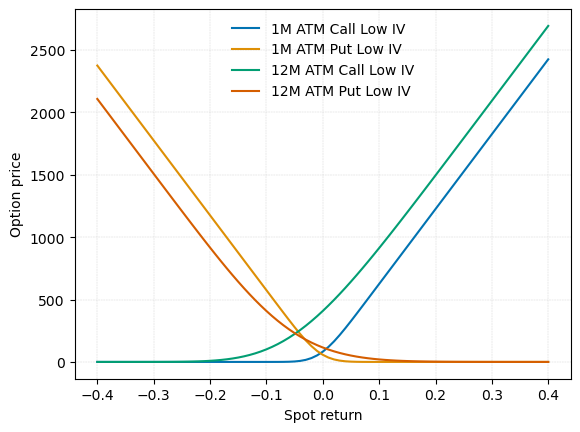

In [8]:
# Create plot
# Use plot_lines with appropriate labels
import warnings
warnings.filterwarnings('ignore')
plot_lines(data=scenario_prices, yaxis_label='Option price', xaxis_label='Spot return')

### Task 3.2: Option Delta Sensitivity Analysis

### Task 3.2.1: Option Delta - Call vs. Put

#### Questions
1. What is the sign of the delta for call and put options? How do you interpret it?
2. What is the delta of a deep ITM and OTM call option? How about a put option? How do you interpret it?
4. What is the delta of an ATM call option? How do you interpret it?
3. What is the relationship between the delta of a call and a put option?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='delta'>)

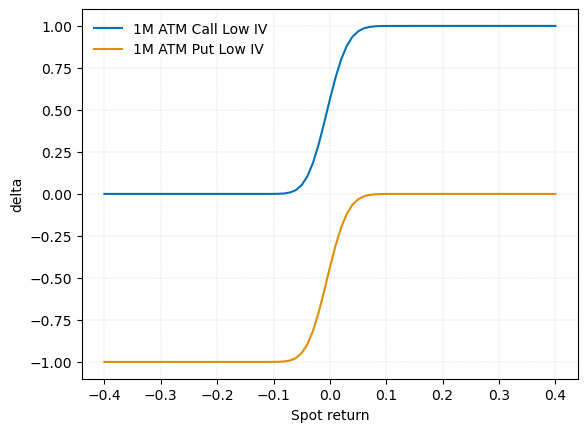

In [10]:
# OPTION DELTA - Call vs. Put

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Put Low IV
2. Generate spot price scenarios using same range
3. Calculate deltas for each spot scenario using bs_delta function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Put Low IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_deltas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate deltas
for i in range(scenario_deltas.shape[0]):
    row_label = scenario_deltas.index[i]
    for col_label in scenario_deltas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      delta_i = bs_delta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_deltas.at[row_label, col_label] = delta_i

# TODO: Create plot
plot_lines(data=scenario_deltas, yaxis_label='delta', xaxis_label='Spot return')

#### Task 3.2.2: Option Delta  - Time to Expiry

#### Questions
1. What is your observation about the pattern of delta for options with different expiries? How do you interpret it?


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='delta'>)

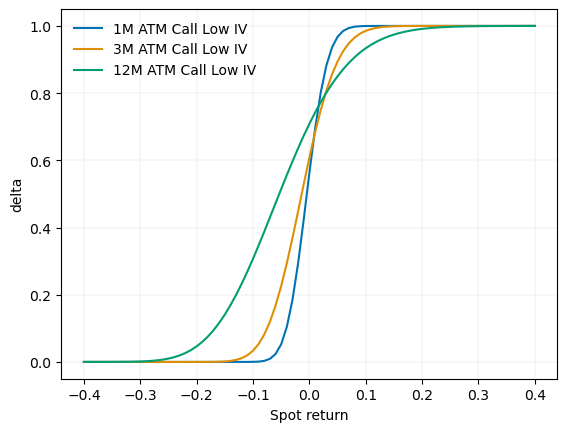

In [11]:
# OPTION DELTA - Time to Expiry
"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 3M ATM Call Low IV
   - 12M ATM Call Low IV
2. Generate spot price scenarios using same range
3. Calculate deltas for each spot scenario using bs_delta function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '3M ATM Call Low IV', '12M ATM Call Low IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_deltas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate deltas
for i in range(scenario_deltas.shape[0]):
    row_label = scenario_deltas.index[i]
    for col_label in scenario_deltas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      delta_i = bs_delta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_deltas.at[row_label, col_label] = delta_i

# TODO: Create plot
plot_lines(data=scenario_deltas, yaxis_label='delta', xaxis_label='Spot return')


#### Task 3.2.3: Option Delta  - IV

#### Questions
1. What is your observation about the pattern of delta for options with different IV? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='delta'>)

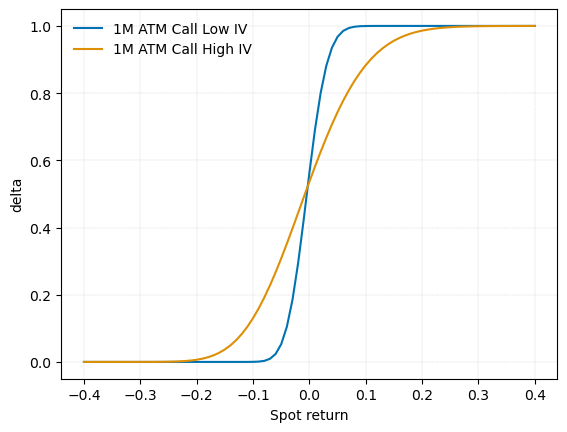

In [12]:
# OPTION DELTA - IV
"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Call High IV

2. Generate spot price scenarios using same range
3. Calculate deltas for each spot scenario using bs_delta function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Call High IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_deltas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate deltas
for i in range(scenario_deltas.shape[0]):
    row_label = scenario_deltas.index[i]
    for col_label in scenario_deltas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      delta_i = bs_delta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_deltas.at[row_label, col_label] = delta_i

# TODO: Create plot
plot_lines(data=scenario_deltas, yaxis_label='delta', xaxis_label='Spot return')


### Task 3.3: Option Gamma Sensitivity Analysis

#### Task 3.3.1 Option Gamma - Call vs. Put

#### Questions
1. What is the sign of the gamma for call and put options? How do you interpret it?
2. What is the relationship between the gamma of a call and a put option?
3. How do you interpret the shape of the gamma curve based on the plot of delta?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='gamma'>)

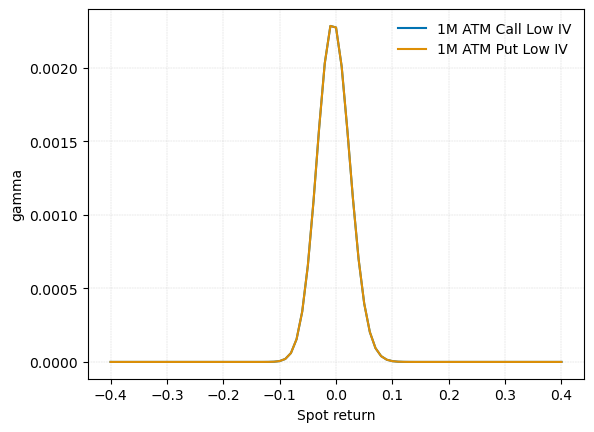

In [ ]:
# OPTION GAMMA SENSITIVITY - Call vs. Put

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Put Low IV
2. Generate spot price scenarios using same range
3. Calculate gammas for each spot scenario using bs_gamma function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Put Low IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_gammas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate gammas
for i in range(scenario_gammas.shape[0]):
    row_label = scenario_gammas.index[i]
    for col_label in scenario_gammas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      gamma_i = bs_gamma(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_gammas.at[row_label, col_label] = gamma_i

# TODO: Create plot
plot_lines(data=scenario_gammas, yaxis_label='gamma', xaxis_label='Spot return')


#### Task 3.3.2 Option Gamma - Time to Expiry

#### Questions
1. What is your observation about the pattern of gamma for options with different expiries?
2. How can you justify your answer using the plot of delta?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='gamma'>)

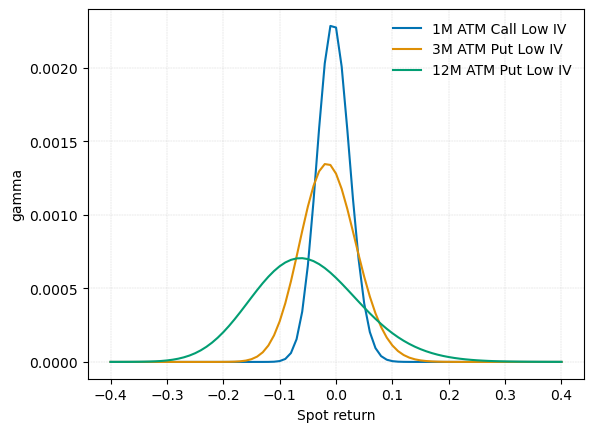

In [ ]:
# OPTION GAMMA SENSITIVITY - Time to Expiry

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 3M ATM Put Low IV
   - 12M ATM Put Low IV
2. Generate spot price scenarios using same range
3. Calculate gammas for each spot scenario using bs_gamma function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '3M ATM Put Low IV', '12M ATM Put Low IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_gammas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate gammas
for i in range(scenario_gammas.shape[0]):
    row_label = scenario_gammas.index[i]
    for col_label in scenario_gammas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      gamma_i = bs_gamma(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_gammas.at[row_label, col_label] = gamma_i

# TODO: Create plot
plot_lines(data=scenario_gammas, yaxis_label='gamma', xaxis_label='Spot return')


#### Task 3.3.3 Option Gamma - IV

#### Questions
1. What is your observation about the pattern of gamma for options with different implied volatility (IV)? How do you interpret it?
2. How can you justify your answer using the plot of delta?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='gamma'>)

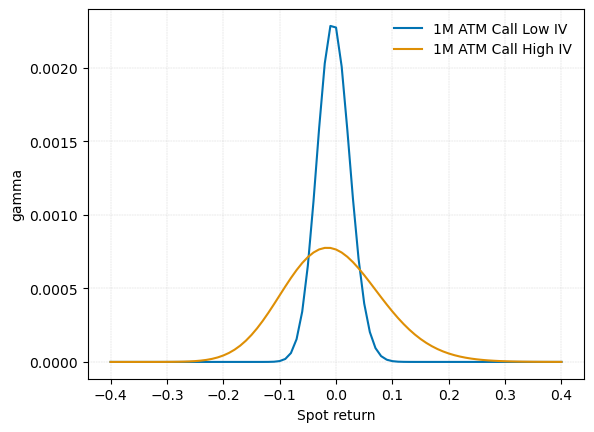

In [ ]:
# OPTION GAMMA SENSITIVITY - IV
"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Call High IV
2. Generate spot price scenarios using same range
3. Calculate gammas for each spot scenario using bs_gamma function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Call High IV']

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_gammas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)

# TODO: Calculate gammas
for i in range(scenario_gammas.shape[0]):
    row_label = scenario_gammas.index[i]
    for col_label in scenario_gammas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      gamma_i = bs_gamma(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_gammas.at[row_label, col_label] = gamma_i

# TODO: Create plot
plot_lines(data=scenario_gammas, yaxis_label='gamma', xaxis_label='Spot return')


#### Task 3.3.4 Option Gamma - Dollar Gamma
#### Dollar Gamma = Gamma * S * S / 100

#### Questions
1. What is your observation about the pattern of dollar gamma for options with different strike?
2. How to construct a portfolio with constant dollar gamma?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='dollar gamma'>)

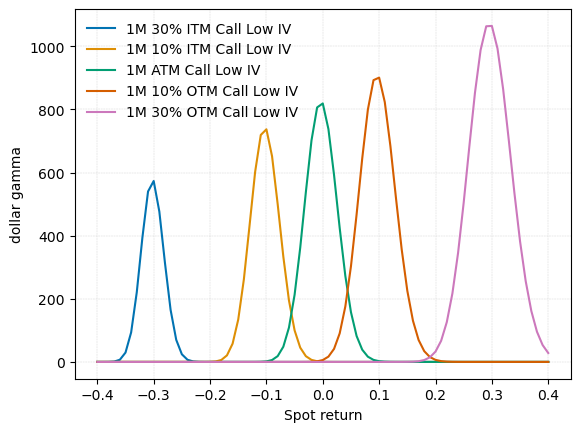

In [17]:
# OPTION DOLLAR GAMMA
"""
TODO Tasks:
1. Use the option belows
   - 1M 30% ITM Call Low IV
   - 1M 10% ITM Call Low IV
   - 1M ATM Call Low IV
   - 1M 10% OTM Call Low IV
   - 1M 30% OTM Call Low IV
2. Generate spot price scenarios using same range
3. Calculate gammas for each spot scenario using bs_gamma function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M 30% ITM Call Low IV', '1M 10% ITM Call Low IV', '1M ATM Call Low IV', '1M 10% OTM Call Low IV', '1M 30% OTM Call Low IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_gammas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate dollar gamma
for i in range(scenario_gammas.shape[0]):
    row_label = scenario_gammas.index[i]
    for col_label in scenario_gammas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      dollar_gamma_i = bs_gamma(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i) * np.square(spot_i)/100

      scenario_gammas.at[row_label, col_label] = dollar_gamma_i

# TODO: Create plot
plot_lines(data=scenario_gammas, yaxis_label='dollar gamma', xaxis_label='Spot return')


### Task 3.4: Option Theta Sensitivity Analysis

#### Task 3.4.1 Option Theta - Call vs. Put

#### Questions
1. What is the sign of theta for call and put options? How do you interpret it?
2. What is the relationship between theta and gamma?
3. Why is theta small for ITM and OTM options but larger for ATM options? How do you interpret it?
4. Why can the theta of a deep ITM put option be positive? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='theta'>)

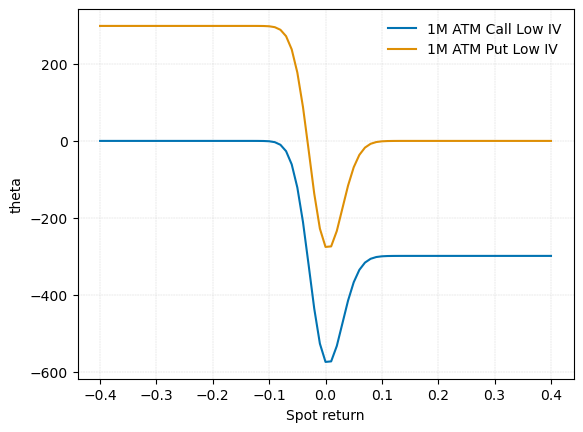

In [19]:
# OPTION THETA SENSITIVITY - Call vs. Put

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Put Low IV
2. Generate spot price scenarios using same range
3. Calculate vegas for each spot scenario using bs_vega function
4. Create plot using plot_lines function with appropriate labels
"""


# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Put Low IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_thetas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate vegas
for i in range(scenario_thetas.shape[0]):
    row_label = scenario_thetas.index[i]
    for col_label in scenario_thetas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      theta_i = bs_theta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_thetas.at[row_label, col_label] = theta_i

# TODO: Create plot
plot_lines(data=scenario_thetas, yaxis_label='theta', xaxis_label='Spot return')

#### Task 3.4.2 Option Theta - Time to Expiry

#### Questions
1. What is your observation about the pattern of theta for options with different expiries? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='theta'>)

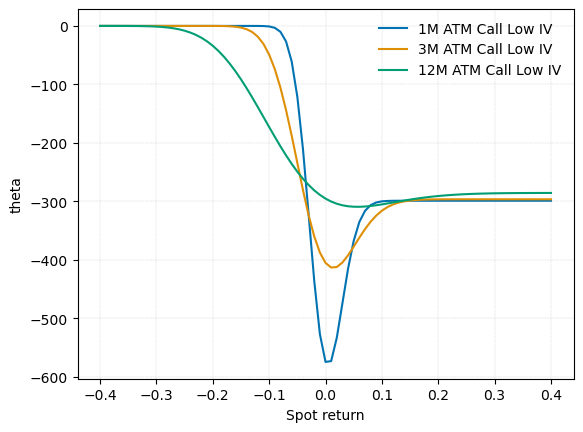

In [20]:
# OPTION THETA SENSITIVITY - Time to Expiry

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 3M ATM Call Low IV
   - 12M ATM Call Low IV
2. Generate spot price scenarios using same range
3. Calculate vegas for each spot scenario using bs_vega function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '3M ATM Call Low IV', '12M ATM Call Low IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_thetas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate vegas
for i in range(scenario_thetas.shape[0]):
    row_label = scenario_thetas.index[i]
    for col_label in scenario_thetas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      theta_i = bs_theta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_thetas.at[row_label, col_label] = theta_i

# TODO: Create plot
plot_lines(data=scenario_thetas, yaxis_label='theta', xaxis_label='Spot return')


#### Task 3.4.3 Option Theta - IV

#### Questions
1. What is your observation about the pattern of theta for options with different IV? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='theta'>)

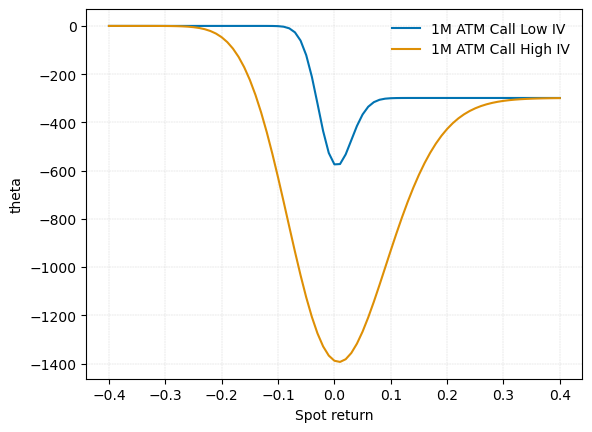

In [21]:
# OPTION THETA SENSITIVITY - IV

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Call High IV
2. Generate spot price scenarios using same range
3. Calculate vegas for each spot scenario using bs_vega function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Call High IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_thetas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate vegas
for i in range(scenario_thetas.shape[0]):
    row_label = scenario_thetas.index[i]
    for col_label in scenario_thetas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      theta_i = bs_theta(spot_i, strike_i, option_type_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_thetas.at[row_label, col_label] = theta_i

# TODO: Create plot
plot_lines(data=scenario_thetas, yaxis_label='theta', xaxis_label='Spot return')


### Task 3.5: Option Vega Sensitivity Analysis

#### Task 3.5.1: Option Vega - Call vs. Put

#### Questions
1. What is the sign of the vega for call and put options? How do you interpret it?
2. What is the relationship between the vega of a call and a put option?
3. What is the vega of a deep ITM and OTM call option? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='vega'>)

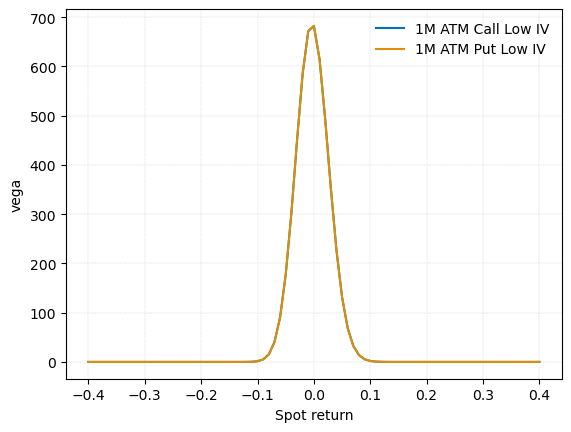

In [23]:
# OPTION VEGA SENSITIVITY - Call vs. Put

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 1M ATM Put Low IV
2. Generate spot price scenarios using same range
3. Calculate vegas for each spot scenario using bs_vega function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '1M ATM Put Low IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_vegas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate vegas
for i in range(scenario_vegas.shape[0]):
    row_label = scenario_vegas.index[i]
    for col_label in scenario_vegas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      vega_i = bs_vega(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_vegas.at[row_label, col_label] = vega_i

# TODO: Create plot
plot_lines(data=scenario_vegas, yaxis_label='vega', xaxis_label='Spot return')


#### Task 3.5.2 Option Vega - Time to Expiry

#### Questions
1. What is your observation about the pattern of vega for options with different expiries? How do you interpret it?

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spot return', ylabel='vega'>)

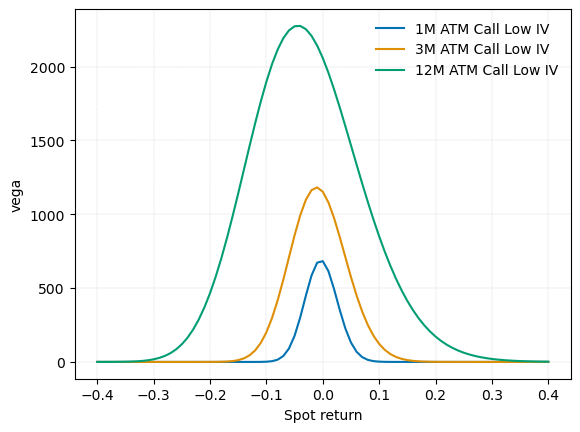

In [24]:
# OPTION VEGA SENSITIVITY - Time to Expiry

"""
TODO Tasks:
1. Use the option belows
   - 1M ATM Call Low IV
   - 3M ATM Call Low IV
   - 12M ATM Call Low IV
2. Generate spot price scenarios using same range
3. Calculate vegas for each spot scenario using bs_vega function
4. Create plot using plot_lines function with appropriate labels
"""

# TODO: Define options to analyze
use_options = ['1M ATM Call Low IV', '3M ATM Call Low IV', '12M ATM Call Low IV']


# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.6, stop=1.4, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot
# Create DataFrame for prices
scenario_vegas = pd.DataFrame(index=scenario_returns, columns=use_options, dtype=np.float64)


# TODO: Calculate vegas
for i in range(scenario_vegas.shape[0]):
    row_label = scenario_vegas.index[i]
    for col_label in scenario_vegas.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']
      
      vega_i = bs_vega(spot_i, strike_i, implied_vol_i, time_to_expiry_i, riskfree_rate_i)

      scenario_vegas.at[row_label, col_label] = vega_i

# TODO: Create plot
plot_lines(data=scenario_vegas, yaxis_label='vega', xaxis_label='Spot return')


## Task 4: Option Strategies and their Greeks

## Task 4.1: Calendar Spread - Long Vega Short Gamma

#### A Calendar Spread is an options trading strategy that involves buying and selling options with the same strike price but different expiration dates.

#### Long Calendar Spread is Buy a longer-term option and Sell a shorter-term option.

#### Questions
What is the Delta, Gamma, and Vega for a Long Calendar Spread strategy?

In [45]:
## Greeks of Calednar Spread

"""
TODO Tasks:
1. Analyze a put spread strategy with:
   - 1M ATM Call Low IV
   - 3M ATM Call Low IV
   
2. For each Greek (price, delta, gamma, vega):
   - Calculate for individual options
   - Calculate net Greek for the spread
   - Create visualization using plot_lines_twoaxes
"""

# TODO: Calednar SPREAD ANALYSIS

long_option = '3M ATM Call Low IV'
short_option = '1M ATM Call Low IV'

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.4, stop=1.2, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot

# TODO: Calculate price, delta, gamma, and vega for the two opiotn
scenario_calendar_spread_price = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_delta = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_gamma = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_vega = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)

for i in range(scenario_calendar_spread_price.shape[0]):
   row_label = scenario_calendar_spread_price.index[i]
   for col_label in scenario_calendar_spread_price.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']

      price_i = bs_price(spot_i,strike_i,option_type_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      delta_i = bs_delta(spot_i,strike_i,option_type_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      gamma_i = bs_gamma(spot_i,strike_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      vega_i = bs_vega(spot_i,strike_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)

      scenario_calendar_spread_price.at[row_label, col_label] = price_i
      scenario_calendar_spread_delta.at[row_label, col_label] = delta_i
      scenario_calendar_spread_gamma.at[row_label, col_label] = gamma_i
      scenario_calendar_spread_vega.at[row_label, col_label] = vega_i

scenario_calendar_spread_price['Net'] = scenario_calendar_spread_price[long_option] - scenario_calendar_spread_price[short_option]
scenario_calendar_spread_delta['Net'] = scenario_calendar_spread_delta[long_option] - scenario_calendar_spread_delta[short_option]
scenario_calendar_spread_gamma['Net'] = scenario_calendar_spread_gamma[long_option] - scenario_calendar_spread_gamma[short_option]
scenario_calendar_spread_vega['Net'] = scenario_calendar_spread_vega[long_option] - scenario_calendar_spread_vega[short_option]


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option price'>,
 <Axes: ylabel='Net m-t-m'>)

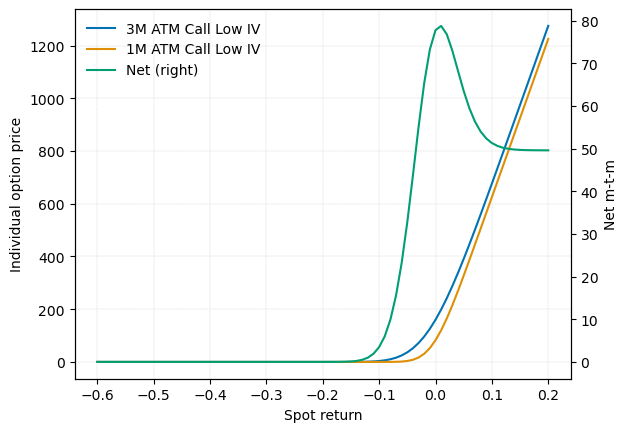

In [ ]:
# scenario_calendar_spread_price
# TODO: Plot price, delta, gamma, and vega
# see below for an example for price
plot_lines_twoaxes(data=scenario_calendar_spread_price, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option price', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option delta'>,
 <Axes: ylabel='Net m-t-m'>)

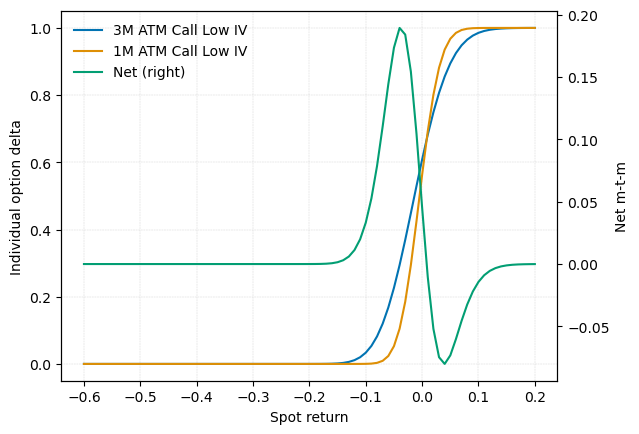

In [47]:
plot_lines_twoaxes(data=scenario_calendar_spread_delta, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option delta', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option gamma'>,
 <Axes: ylabel='Net m-t-m'>)

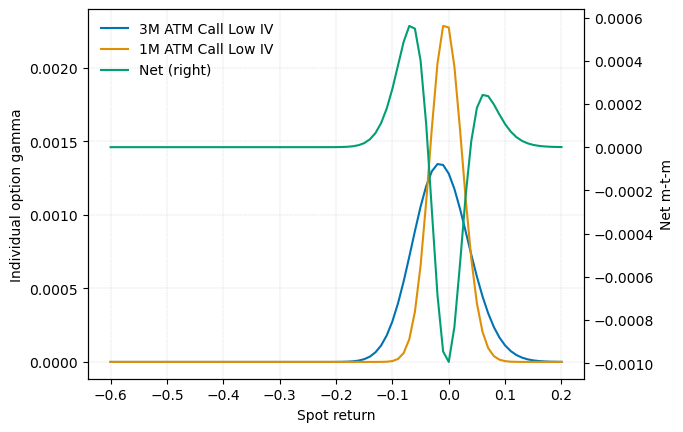

In [48]:
plot_lines_twoaxes(data=scenario_calendar_spread_gamma, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option gamma', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option vega'>,
 <Axes: ylabel='Net m-t-m'>)

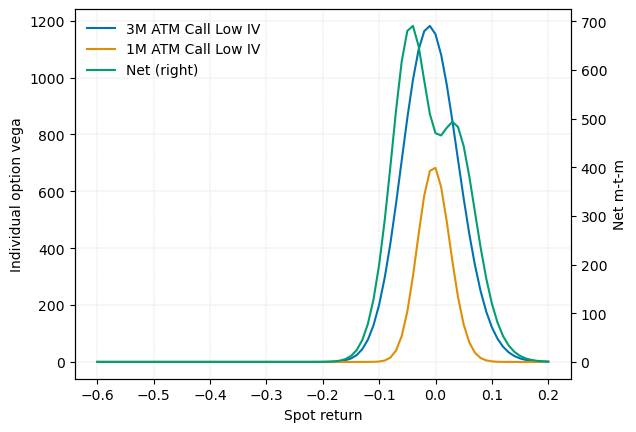

In [49]:
plot_lines_twoaxes(data=scenario_calendar_spread_vega, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option vega', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

## Task 4.2: Bull Spread

#### A bull spread is an options trading strategy that is used to profit from a moderate increase in the price of an underlying asset. It involves buying and selling call or put options with the same expiration date but different strike prices. 

#### We would buy a call option with a lower strike price, and sell a call option with a higher strike price.

#### Questions
What is the PnL, Delta, Gamma, and Vega for a Bull Spread strategy?

In [55]:
## Greeks of Bull Spread

"""
TODO Tasks:
1. Analyze a put spread strategy with:
   - 1M 10% OTM Call Low IV
   - 1M 30% OTM Call Low IV
   
2. For each Greek (price, delta, gamma, vega):
   - Calculate for individual options
   - Calculate net Greek for the spread
   - Create visualization using plot_lines_twoaxes
"""

# TODO: BULL SPREAD ANALYSIS

long_option = '1M 10% OTM Call Low IV'
short_option = '1M 30% OTM Call Low IV'

# TODO: Generate spot price scenarios
scenario_returns = np.linspace(start=0.4, stop=2, num=81) - 1.
scenario_spots = (scenario_returns + 1.) * spot

# TODO: Calculate price, delta, gamma, and vega for the two opiotn
scenario_calendar_spread_price = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_delta = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_gamma = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)
scenario_calendar_spread_vega = pd.DataFrame(index=scenario_returns, columns=[long_option,short_option], dtype=np.float64)

for i in range(scenario_calendar_spread_price.shape[0]):
   row_label = scenario_calendar_spread_price.index[i]
   for col_label in scenario_calendar_spread_price.columns:
      spot_i = scenario_spots[i]
      strike_i = options.loc[col_label, 'strike']
      time_to_expiry_i = options.loc[col_label, 'time_to_expiry']
      option_type_i = options.loc[col_label, 'option_type']
      implied_vol_i = options.loc[col_label, 'implied_vol']
      riskfree_rate_i = options.loc[col_label, 'riskfree_rate']

      price_i = bs_price(spot_i,strike_i,option_type_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      delta_i = bs_delta(spot_i,strike_i,option_type_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      gamma_i = bs_gamma(spot_i,strike_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)
      vega_i = bs_vega(spot_i,strike_i,implied_vol_i,time_to_expiry_i,riskfree_rate_i)

      scenario_calendar_spread_price.at[row_label, col_label] = price_i
      scenario_calendar_spread_delta.at[row_label, col_label] = delta_i
      scenario_calendar_spread_gamma.at[row_label, col_label] = gamma_i
      scenario_calendar_spread_vega.at[row_label, col_label] = vega_i

scenario_calendar_spread_price['Net'] = scenario_calendar_spread_price[long_option] - scenario_calendar_spread_price[short_option]
scenario_calendar_spread_delta['Net'] = scenario_calendar_spread_delta[long_option] - scenario_calendar_spread_delta[short_option]
scenario_calendar_spread_gamma['Net'] = scenario_calendar_spread_gamma[long_option] - scenario_calendar_spread_gamma[short_option]
scenario_calendar_spread_vega['Net'] = scenario_calendar_spread_vega[long_option] - scenario_calendar_spread_vega[short_option]


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option price'>,
 <Axes: ylabel='Net m-t-m'>)

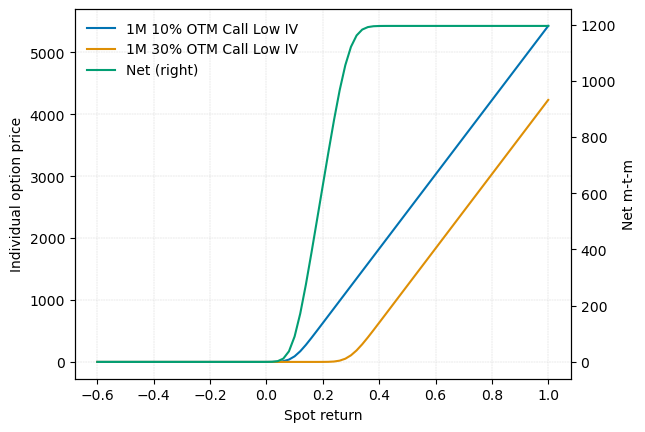

In [59]:
# scenario_calendar_spread_price
# TODO: Plot price, delta, gamma, and vega
# see below for an example for price
plot_lines_twoaxes(data=scenario_calendar_spread_price, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option price', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option delta'>,
 <Axes: ylabel='Net m-t-m'>)

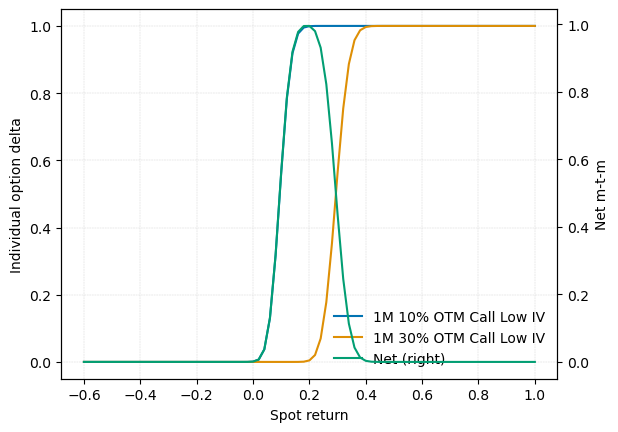

In [56]:
plot_lines_twoaxes(data=scenario_calendar_spread_delta, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option delta', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option gamma'>,
 <Axes: ylabel='Net m-t-m'>)

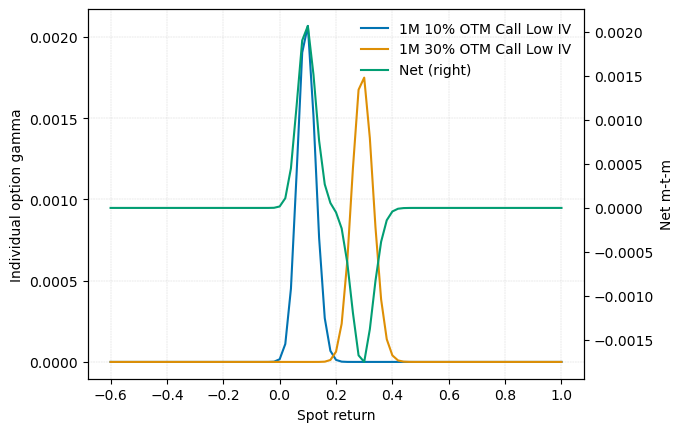

In [57]:
plot_lines_twoaxes(data=scenario_calendar_spread_gamma, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option gamma', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Spot return', ylabel='Individual option vega'>,
 <Axes: ylabel='Net m-t-m'>)

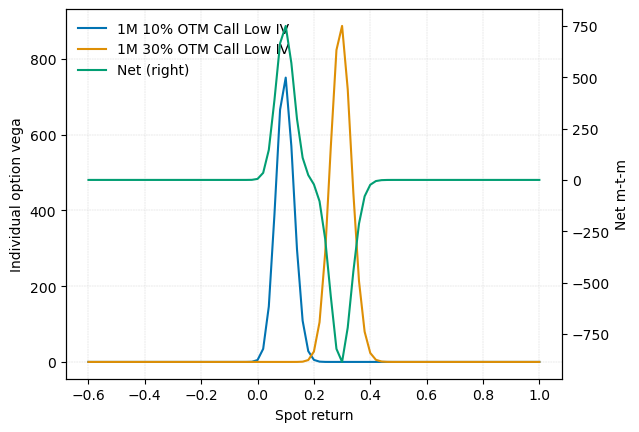

In [58]:
plot_lines_twoaxes(data=scenario_calendar_spread_vega, primary_columns=[long_option, short_option], secondary_columns=['Net'], 
                   primary_yaxis_label='Individual option vega', secondary_yaxis_label='Net m-t-m', 
                   xaxis_label='Spot return')